In [31]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
from src.input import *
from src.distributions import f_FD
from src.units import UNITS
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from matplotlib import cm
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib
plt.style.use("template.mplstyle")

### Fig 1

In [32]:
def xi(z, zi, z0):
    """ Time dependence of halo growth. """
    if z < zi:
        return (zi - z) / (zi - z0)
    else:
        return 0.0

def I(c):
    """ Radial mass profile for NFW halo. """
    return np.log(1.0 + c) - c / (1.0 + c)

def mod_func(redshift, final_redshift, power):
    z_i = final_redshift
    #200 times critical density at previous redshift
    z_0 = ((1 + z_i) / 200**(1/3)) - 1
    if redshift < z_i:
        mod = np.where(redshift >= z_0, ((z_i - redshift) / (z_i - z_0))**power, 1)  
    else:
        mod = 0
    return mod


def Phi_C_1e15(r, z):
    """ Compute the gravitational potential for radial position and redshift """
    # Define constants
    M12 = 1.0e3
    z0 = 0.0
    c = 4.43 #value of concentration parameter at z=0 as discussed in the paper
    
    # Compute intermediate values
    zi = (200.0 ** (1.0 / 3.0)) * (1.0 + z0) - 1.0
    Ri = 1.77 * (M12 ** (1.0 / 3.0))
    r200 = Ri / (1.0 + zi)
    rs = r200 / c
    GM = 4.375e3 * M12
   
    # Initialize the answer array
    phi_arr = np.zeros_like(r, dtype=float)
    
    # Loop through each element in r
    for i in range(len(r)):
        current_r = r[i]
        xi_z = xi(z, zi, z0)
        
        if current_r < r200 * (1.0 + z):
            term1 = -GM * (1.0 + z) * xi_z * (
                1.0 / current_r / I(c) * np.log(1.0 + current_r / rs / (1.0 + z))
                - 1.0 / (r200 * (1.0 + z)) / I(c) * np.log(1.0 + c)
                + 1.0 / (r200 * (1.0 + z))
            )
            term2 = GM * xi_z * (1.0 + z) * (3.0 * Ri**2 - current_r**2) / (2.0 * Ri**3)
            phi_arr[i] = term1 + term2
            
        elif r200 * (1.0 + z) <= current_r < Ri:
            term1 = -GM * xi_z * (1.0 + z) / current_r
            term2 = GM * xi_z * (1.0 + z) * (3.0 * Ri**2 - current_r**2) / (2.0 * Ri**3)
            phi_arr[i] = term1 + term2
            
        else:
            phi_arr[i] = 0.0
    
    return phi_arr

def rho_NFW(r, redshift, Mh):
    """ Compute the NFW radial mass density for radial position, redshift, and DM halo mass """
    if redshift >= 4:
        conc = 10 ** (
            1.3081
            - 0.1078 * (1 + redshift)
            + 0.00398 * (1 + redshift) ** 2
            + (0.0223 - 0.0944 * (1 + redshift) ** (-0.3907))
            * np.log10(Mh / UNITS.MSun)
        )
    else:
        conc = 10 ** (
            1.7543
            - 0.2766 * (1 + redshift)
            + 0.02039 * (1 + redshift) ** 2
            + (0.2753 + 0.00351 * (1 + redshift) - 0.3038 * (1 + redshift) ** 0.0269)
            * np.log10(Mh / UNITS.MSun)
            * (
                1.0
                + (-0.01537 + 0.02102 * (1 + redshift) ** (-0.1475))
                * (np.log10(Mh / UNITS.MSun)) ** 2
            )
        )
    
    Ri = 1.77 * (Mh / 1e12 / UNITS.MSun)**(1/3) * UNITS.Mpc
    R200 = Ri / (1 + z_end)
    Rs = R200 / conc
    rhoS = Mh / (4.0 * np.pi * Rs**3 * (np.log(1 + conc) - conc / (1.0 + conc)))
    xs = conc * r / R200
    
    return rhoS / (xs * (1 + xs)**2) 


def rho_NFW_acrossz_1e15(r, z): 
    """ Compute the NFW radial mass density for a 10^15 MSun DM halo for radial position and redshift """
    """ Normalized to background matter density """
    r200 = 3.026 * (1 + z)
    Ri = 17.7 
    background_matter_dens = (0.24) * 9.9 * 1e-30 * UNITS.g / UNITS.cm**3
    answer = np.zeros_like(r, dtype=float)
    
    #then radial sorting with respect to r200
    for i in range(len(r)):
        current_r = r[i]

        if current_r < r200:
            rho_NFW_func = rho_NFW(current_r * UNITS.Mpc, z, 1e15 * UNITS.MSun) #second term is redshift, so conc = 9
            answer[i] = (mod_func(z, 4.848, 1) * rho_NFW_func + (1 - mod_func(z, 4.848, 1)) * background_matter_dens) / background_matter_dens
            
        elif r200 <= current_r < Ri:
            answer[i] = np.full_like(current_r, ((1 - mod_func(z, 4.848, 1)) * background_matter_dens)) / background_matter_dens
            
        else: #some small non-zero value
            answer[i] = 1e-20
    return answer

In [4]:
dens_1e15_03eV_overallz = np.load('data/dens_1e15_03eV_overallz.npy')
dens_1e15_03eV_overallz = np.squeeze(dens_1e15_03eV_overallz)
params_nu = np.linspace(0, 4.83, 100) 

# Interpolation function along the time axis for each position
nu_1e15_num_interpolated_steps = 1000  #determines smoothness for interpolation
nu_1e15_interpolated_z_start = np.linspace(params_nu[0], params_nu[-1], nu_1e15_num_interpolated_steps)
nu_1e15_interpolated_densities = np.zeros((nu_1e15_num_interpolated_steps, dens_1e15_03eV_overallz.shape[1]))

for j in range(dens_1e15_03eV_overallz.shape[1]):
    f_interp = interp1d(params_nu, dens_1e15_03eV_overallz[:, j], kind='cubic')
    nu_1e15_interpolated_densities[:, j] = f_interp(nu_1e15_interpolated_z_start)

n_nu_background = 3.0 * 1.202 * Tnu_0**3 / 4.0 / np.pi**2
n_DM_background = (0.24) * 9.9 * 1e-30 * UNITS.g / UNITS.cm**3

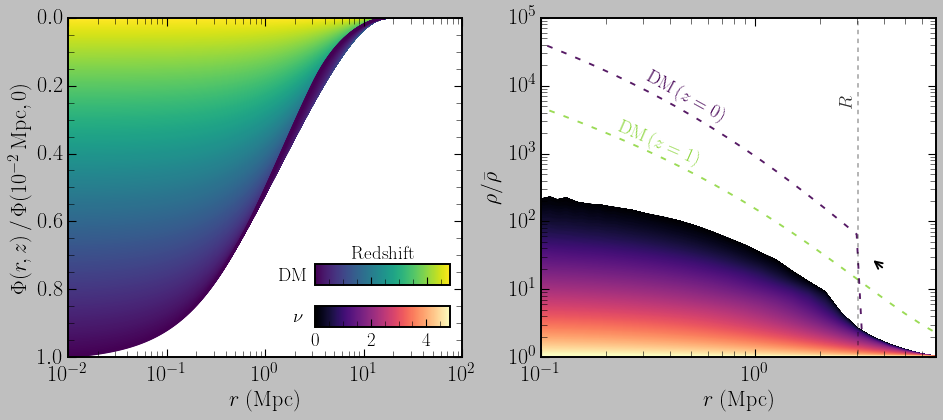

In [188]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5.3))

# Phi parameters
h_val = 0.68
r_Phi_test = np.geomspace(1e-2, 5e1, 100) #/ h_val
z_Phi_test = np.linspace(4.8, 0, 1000) 
r_array_5e1 = np.geomspace(1e-2, 5e1, 50) * h_val

# Generate parameter values and colormap for both plots
params = np.geomspace(0.01, 4.8, 2000) ### Redshift range
cmap1 = cm.viridis
norm1 = Normalize(vmin=0, vmax=4.8)
colors1 = cmap1(norm1(params))

#normalizing factor for nice Phi(r) plot
norm_fact = -Phi_C_1e15(r_Phi_test, 0).min()
for z in z_Phi_test:
    phi_values = Phi_C_1e15(r_Phi_test, z)
    ax1.semilogx(r_Phi_test, -phi_values / norm_fact, color=cmap1(norm1(z)))  

ax1.text(1.36, 0.775, r'$\mathrm{DM}$', fontsize=17)
ax1.text(1.9, 0.895, r'$\nu$', fontsize=17)


ax1.set_xlabel(r'$r\ (\mathrm{Mpc})$', fontsize=20)
ax1.set_ylabel(r'$\Phi(r,z)\, /\, \Phi(10^{-2}\,\mathrm{Mpc}, 0)$', fontsize=20)
ax1.set_xscale('log')
ax1.set_yscale('linear')
# ax1.vlines(17.7, np.min(-Phi_C_1e15(r_Phi_test, 0)/ norm_fact), np.max(-Phi_C_1e15(r_Phi_test, 0)/ norm_fact), linestyle=(3.9,(4,4)), color="black", alpha=0.3)
ax1.invert_yaxis()
ax1.tick_params(axis='x', pad=6)
# ax1.legend(markerfirst=False, fontsize=13, frameon = False, loc='lower right', bbox_to_anchor=(1.02, 0.0))

# Subplot 2
# DM density ### Params dictates redshift
ax2.semilogy(r_array_5e1, rho_NFW_acrossz_1e15(r_array_5e1, params[0]), color=colors1[0], alpha=0.9, linestyle = 'dashed')
# ax2.semilogy(r_array_5e1, rho_NFW_acrossz_1e15(r_array_5e1, params[1500]), color=colors1[1500], alpha=0.9, label=r'$\mathrm{DM}\, (z=1)$', linestyle = 'dashed')
# ax2.semilogy(r_array_5e1, rho_NFW_acrossz_1e15(r_array_5e1, params[1716]), color=colors1[1716], alpha=0.9, label=r'$\mathrm{DM}\, (z=2)$', linestyle = 'dashed')
# ax2.semilogy(r_array_5e1, rho_NFW_acrossz_1e15(r_array_5e1, params[1850]), color=colors1[1850], alpha=0.9, label=r'$\mathrm{DM}\, (z=3)$', linestyle = 'dashed')
ax2.semilogy(r_array_5e1, rho_NFW_acrossz_1e15(r_array_5e1, params[1940]), color=colors1[1940], alpha=0.9, linestyle = 'dashed')
ax2.annotate('', xy=(3.5, 28), xytext=(4, 20), arrowprops=dict(arrowstyle='->'))
ax2.text(2.45, 5000, r'$R$', fontsize=17, rotation=90, color="black", alpha=0.8)
ax2.text(0.3, 2950, r'$\mathrm{DM}\, (z=0)$', color=colors1[0], alpha=1., fontsize=17, rotation=-29)
ax2.text(0.22, 690, r'$\mathrm{DM}\, (z=1)$', color=colors1[1940], alpha=1., fontsize=17, rotation=-23.5)
ax2.tick_params(axis='x', pad=6)



# Neutrino density, interpolated in the range (z = 3.1 to z = 0)
nu_1e15_interpolated_z_start = np.geomspace(0.01, 3.1, nu_1e15_interpolated_densities.shape[0])
cmap2 = cm.magma
norm2 = Normalize(vmin=0, vmax=4.85)  # Colorbar will span 0 to 4.85
for i, color in enumerate(cmap2(Normalize(vmin=0, vmax=3.1)(nu_1e15_interpolated_z_start[5:]))):
    ax2.semilogy(r_array_5e1, nu_1e15_interpolated_densities[i, :], color=color)
 
ax2.set_xlabel(r'$r\ (\mathrm{Mpc})$', fontsize=20)
ax2.set_ylabel(r'$\rho / \bar{\rho}$', fontsize=20)
ax2.set_xlim(0.1, 7) 
ax2.set_ylim(1, 1e5)
ax2.vlines(3.026, 0, 1e5, linestyle=(3.9,(4,4)), color="black", alpha=0.3)

# ax2.legend(loc='upper right', markerfirst = False, fontsize=17, frameon = False)  
ax2.set_xscale('log')

cax1 = fig.add_axes([0.346, 0.27, 0.12, 0.05])  # [left, bottom, width, height] in figure coordinates
cbar1 = fig.colorbar(matplotlib.cm.ScalarMappable(cmap=cmap1, norm=norm1), cax=cax1, orientation='horizontal')
cbar1.set_ticks([0, 2, 4])
cbar1.set_ticklabels([])
cbar1.set_label(r'$\mathrm{Redshift}$', fontsize=17)
cbar1.ax.xaxis.set_label_position('top')

# Second colorbar is the full z-range (0 to 4.85)
cax2 = fig.add_axes([0.346, 0.17, 0.12, 0.05])
cbar2 = fig.colorbar(matplotlib.cm.ScalarMappable(cmap=cmap2, norm=norm2), cax=cax2, orientation='horizontal')
cbar2.set_ticks([0, 2, 4])
cbar2.ax.tick_params(labelsize=17)
cbar2.ax.xaxis.set_label_position('top')

plt.savefig('main_plot_potentials.pdf')

### Fig 2

In [ ]:
dens_allhalos_3mass = np.load('data/overdensity_allhalos_3mass.npy')
dens_allhalos_maxmass = np.load('data/overdensity_allhalos_maxmass.npy')
#shape [Mh, r, m_nu]
#the 4 neutrino masses are [0.06,0.15,0.3,0.5] eV

h_val = 0.68
r_array_5e1 = np.geomspace(1e-2, 5e1, 50) * h_val
r_array_5e1_200vals = np.geomspace(1e-2, 5e1, 200) * h_val
Ri_array = np.array([1.77, 3.81, 8.22, 17.7])
R200_array = np.array([0.303, 0.651, 1.405, 3.026])

fig, axs = plt.subplots(2, 2, figsize=(12, 4))
axs[0, 0].loglog(r_array_5e1, dens_allhalos_3mass[3,:,0], linewidth = 1, label = '$10^{15}$ $M_{\odot}$')
axs[0, 0].loglog(r_array_5e1, dens_allhalos_3mass[2,:,0], linewidth = 1, label = '$10^{14}$ $M_{\odot}$')
axs[0, 0].loglog(r_array_5e1, dens_allhalos_3mass[1,:,0], linewidth = 1, label = '$10^{13}$ $M_{\odot}$')
axs[0, 0].loglog(r_array_5e1, dens_allhalos_3mass[0,:,0], linewidth = 1, label = '$10^{12}$ $M_{\odot}$')
axs[0, 0].legend(fontsize=10.5, loc='upper left', frameon = False)

axs[0, 1].loglog(r_array_5e1, dens_allhalos_3mass[3,:,1], linewidth = 1)
axs[0, 1].loglog(r_array_5e1, dens_allhalos_3mass[2,:,1], linewidth = 1)
axs[0, 1].loglog(r_array_5e1, dens_allhalos_3mass[1,:,1], linewidth = 1)
axs[0, 1].loglog(r_array_5e1, dens_allhalos_3mass[0,:,1], linewidth = 1)

axs[1, 0].loglog(r_array_5e1, dens_allhalos_3mass[3,:,2], linewidth = 1)
axs[1, 0].loglog(r_array_5e1, dens_allhalos_3mass[2,:,2], linewidth = 1)
axs[1, 0].loglog(r_array_5e1, dens_allhalos_3mass[1,:,2], linewidth = 1)
axs[1, 0].loglog(r_array_5e1, dens_allhalos_3mass[0,:,2], linewidth = 1)

axs[1, 1].loglog(r_array_5e1_200vals, dens_allhalos_maxmass[3,:,0], linewidth = 1)
axs[1, 1].loglog(r_array_5e1_200vals, dens_allhalos_maxmass[2,:,0], linewidth = 1)
axs[1, 1].loglog(r_array_5e1_200vals, dens_allhalos_maxmass[1,:,0], linewidth = 1)
axs[1, 1].loglog(r_array_5e1_200vals, dens_allhalos_maxmass[0,:,0], linewidth = 1)

for ax_row in axs:
    for ax in ax_row:
        ax.set_xlim(5e-2, 30)
        ax.set_ylim(5e-1, 2e3)

#Optional axes cleanup
axs[0, 0].set_xticklabels([])
axs[0, 1].set_xticklabels([])
axs[0, 1].set_yticklabels([])
axs[1, 1].set_yticklabels([])

colors = ['#d62728', '#2ca02c', '#ff7f0e', '#1f77b4']

for i in range(4):
    axs[0,0].text(R200_array[i], 30, '$R_{200}$', rotation=270, verticalalignment='bottom', color=colors[i])
    for ax in axs.flatten():
        ax.vlines(R200_array[i], 5e-1, 2e3, linestyle='dotted', color=colors[i])
        ax.hlines(1, 1e-2, 5e1, linestyle = 'dashed', alpha = 0.2)

fig.text(0.42, 0.9, r'$m_{\nu}$ = 0.06 eV', ha='center', fontsize = 13)
fig.text(0.91, 0.9, r'$m_{\nu}$ = 0.15 eV', ha='center', fontsize = 13)
fig.text(0.42, 0.44, r'$m_{\nu}$ = 0.3 eV', ha='center', fontsize = 13)
fig.text(0.91, 0.44, r'$m_{\nu}$ = 0.5 eV', ha='center', fontsize = 13)

fig.text(0.5, -0.03, 'r (Mpc)', ha='center', fontsize = 14)
fig.text(-0.015, 0.5, r'$n_{\nu}$ / $\overline{n}_{\nu}$', va='center', rotation='vertical', fontsize = 15)

plt.tight_layout()
plt.savefig('plot_save_vehicle.pdf', bbox_inches='tight')
plt.show()

### Fig 3

In [ ]:
integrands_allhalos_4mass = np.load('data/integrands_allhalos_4mass.npy')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

#used higher p sampling for this plot
alt_p_arr_2 = np.geomspace(0.01, 40, 2000)
#within r_array_5e1, Ri is indices of [7, 13, 18, 24]

#normalized integrands
ax1.plot(alt_p_arr_2, integrands_allhalos_4mass[0, 30, 2, :] / Tnu_0**2 / np.sum(integrands_allhalos_4mass[0, 30, 2, :] / Tnu_0**2), label=r'$10^{12} \, M_\odot$')
ax1.plot(alt_p_arr_2, integrands_allhalos_4mass[1, 34, 2, :] / Tnu_0**2 / np.sum(integrands_allhalos_4mass[1, 34, 2, :] / Tnu_0**2), label=r'$10^{13} \, M_\odot$')
ax1.plot(alt_p_arr_2, integrands_allhalos_4mass[2, 39, 2, :] / Tnu_0**2 / np.sum(integrands_allhalos_4mass[2, 39, 2, :] / Tnu_0**2), label=r'$10^{14} \, M_\odot$')
ax1.plot(alt_p_arr_2, integrands_allhalos_4mass[3, 43, 2, :] / Tnu_0**2 / np.sum(integrands_allhalos_4mass[3, 43, 2, :] / Tnu_0**2), label=r'$10^{15} \, M_\odot$')
#ax1.set_xlabel(r'$p \, / \, T_\nu$', fontsize = 15)
ax1.set_ylabel(r'$f_{\mathrm{today}}(p)$', fontsize = 14)
ax1.set_title('$r_i$', fontsize = 15)
#ax1.vlines([1.44, 3.12, 6.71, 14.46], 0, 0.011, linestyle='dotted')
ax1.vlines(1.44, 0, 0.003, linestyle='dotted', color = '#1f77b4')
ax1.vlines(3.12, 0, 0.003, linestyle='dotted', color = '#ff7f0e')
ax1.vlines(6.71, 0, 0.003, linestyle='dotted', color = '#2ca02c')
ax1.vlines(14.46, 0, 0.003, linestyle='dotted', color = '#d62728')
ax1.set_xlim(0, 22)
ax1.legend(markerfirst=False, frameon=False, loc='upper left', bbox_to_anchor=(0.63, 0.95), fontsize = 13)

ax2.plot(alt_p_arr_2, integrands_allhalos_4mass[0, 20, 2, :] / Tnu_0**2 / np.sum(integrands_allhalos_4mass[0, 20, 2, :] / Tnu_0**2))
ax2.plot(alt_p_arr_2, integrands_allhalos_4mass[1, 24, 2, :] / Tnu_0**2 / np.sum(integrands_allhalos_4mass[1, 24, 2, :] / Tnu_0**2))
ax2.plot(alt_p_arr_2, integrands_allhalos_4mass[2, 28, 2, :] / Tnu_0**2 / np.sum(integrands_allhalos_4mass[2, 28, 2, :] / Tnu_0**2))
ax2.plot(alt_p_arr_2, integrands_allhalos_4mass[3, 33, 2, :] / Tnu_0**2 / np.sum(integrands_allhalos_4mass[3, 33, 2, :] / Tnu_0**2))
ax2.set_xlabel(r'$p \, / \, T_\nu$', fontsize = 15)
#ax2.set_ylabel(r'$f_{\mathrm{today}}(p)$', fontsize = 14)
ax2.set_title('$r_{200}$', fontsize = 15)
#ax2.vlines([1.44, 3.12, 6.71, 14.46], 0, 0.023, linestyle='dotted')
ax2.vlines(1.44, 0, 0.006, linestyle='dotted', color = '#1f77b4')
ax2.vlines(3.12, 0, 0.006, linestyle='dotted', color = '#ff7f0e')
ax2.vlines(6.71, 0, 0.006, linestyle='dotted', color = '#2ca02c')
ax2.vlines(14.46, 0, 0.006, linestyle='dotted', color = '#d62728')
ax2.set_xlim(0, 22)

ax3.plot(alt_p_arr_2, integrands_allhalos_4mass[0, 7, 2, :] / Tnu_0**2 / np.sum(integrands_allhalos_4mass[0, 7, 2, :] / Tnu_0**2))
ax3.plot(alt_p_arr_2, integrands_allhalos_4mass[1, 13, 2, :] / Tnu_0**2 / np.sum(integrands_allhalos_4mass[1, 13, 2, :] / Tnu_0**2))
ax3.plot(alt_p_arr_2, integrands_allhalos_4mass[2, 18, 2, :] / Tnu_0**2 / np.sum(integrands_allhalos_4mass[2, 18, 2, :] / Tnu_0**2))
ax3.plot(alt_p_arr_2, integrands_allhalos_4mass[3, 24, 2, :] / Tnu_0**2 / np.sum(integrands_allhalos_4mass[3, 24, 2, :] / Tnu_0**2))
#ax3.set_xlabel(r'$p \, / \, T_\nu$', fontsize = 15)
#ax3.set_ylabel(r'$f_{\mathrm{today}}(p)$', fontsize = 14)
ax3.set_title('$r_s$', fontsize = 15)
#ax3.vlines([1.44, 3.12, 6.71, 14.46], 0, 0.04, linestyle='dotted')
ax3.vlines(1.44, 0, 0.01, linestyle='dotted', color = '#1f77b4')
ax3.vlines(3.12, 0, 0.01, linestyle='dotted', color = '#ff7f0e')
ax3.vlines(6.71, 0, 0.01, linestyle='dotted', color = '#2ca02c')
ax3.vlines(14.46, 0, 0.01, linestyle='dotted', color = '#d62728')
ax3.set_xlim(0, 22)

#fig.suptitle('Integrands for 0.3 eV', fontsize = 14)
plt.tight_layout()
plt.savefig('plot_save_vehicle.pdf')
plt.show()

### Fig 4

In [ ]:
def mod_func_simp(redshift, final_redshift, power):
    z_i = final_redshift
    # 200 times critical density at previous redshift
    z_0 = ((1 + z_i) / 200**(1/3)) - 1
    mod = np.where(redshift < z_i, np.where(redshift >= z_0, ((z_i - redshift) / (z_i - z_0))**power, 1), 0)    
    return mod

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4), gridspec_kw={'width_ratios': [1, 1, 1.5]})

# Subplot 1
dens_mod_funcs = np.load('data/dens_mod_funcs.npy')
z_alt_arr = np.linspace(0, 4.85, 100)
zi10_arr = np.linspace(0, 10, 100)
zi20_arr = np.linspace(0, 20, 100)

ax1.plot(z_alt_arr, mod_func_simp(z_alt_arr, 4.85, 1), label='$z_i = 4.85$')
ax1.plot(zi10_arr, mod_func_simp(zi10_arr, 10, 1), label='$z_i = 10$')
ax1.plot(zi20_arr, mod_func_simp(zi20_arr, 20, 1), label='$z_i = 20$')
ax1.set_xlabel('redshift', fontsize = 16)
ax1.set_ylabel(r'$\xi$ (z)', fontsize=18)
ax1.legend(markerfirst=False, frameon=False, fontsize = 15)

# Subplot 2
ax2.plot(z_alt_arr, mod_func_simp(z_alt_arr, 4.85, 1))
ax2.plot(z_alt_arr, mod_func_simp(z_alt_arr, 4.85, 0.5))
ax2.plot(z_alt_arr, mod_func_simp(z_alt_arr, 4.85, 3))
ax2.plot(z_alt_arr, mod_func_simp(z_alt_arr, 4.85, 50), label='50th power', linestyle = 'dashed', color = 'black')
ax2.plot(z_alt_arr, mod_func_simp(z_alt_arr, 4.85, 1/50))
ax2.set_xlabel('redshift', fontsize = 15)
ax2.set_ylabel(r'$\xi$ (z)', fontsize = 18)
ax2.legend(frameon = False, bbox_to_anchor=(0.30, 0.12), loc='center', fontsize = 15) 

# Subplot 3
ax3.loglog(r_array_5e1, dens_mod_funcs[0,:])
ax3.loglog(r_array_5e1, dens_mod_funcs[1,:])
ax3.loglog(r_array_5e1, dens_mod_funcs[2,:])
ax3.loglog(r_array_5e1, dens_mod_funcs[3,:])
ax3.loglog(r_array_5e1, dens_mod_funcs[4,:], label='50th power', linestyle = 'dashed', color = 'black')
ax3.loglog(r_array_5e1, dens_mod_funcs[5,:], label = '$z_i = 10$')
ax3.loglog(r_array_5e1, dens_mod_funcs[6,:], label = '$z_i = 20$')
ax3.set_xlabel('r (Mpc / h)', fontsize = 16)
ax3.set_ylabel(r'$n_{\nu} / \overline{n_{\nu}\,}$', fontsize=18)
ax3.legend(markerfirst=False, frameon=False, fontsize = 15)
plt.tight_layout()
plt.savefig('plot_save_vehicle.pdf')

### Fig 5

In [ ]:
## all the values chosen are to reflect constant Neff ##
def Gaussian_distribution(Amp, y, sigma, p):
    p_arr = p / Tnu_0
    Gaussian = np.exp(((p_arr - y)**2) / (sigma**2) / -2)
    return (Amp * Gaussian)

def f_FD_low_temp(p):
    Tnu = 1.3625 * UNITS.K
    return np.power(1 + np.exp(p / Tnu), -1.0)

def f_dropoff(p):
    # Plateau value
    p_0 = 1.1
    plateau_value = 0.5
    alpha = 3.5
    T_nu_0 = 1.3625 * UNITS.K
    p = p / T_nu_0
    # Exponential decay function after p_0
    return np.where(p <= p_0, plateau_value, plateau_value * np.exp(-alpha * (p - p_0)))

def f_fermionic_freezein(p):
    Tnu = 1.95 * UNITS.K
    return np.power(p / Tnu, -2.0) / (1 + np.exp(p / Tnu))

def f_bosonic_freezein(p):
    Tnu = 1.95 * UNITS.K
    return np.power(np.exp(p / Tnu) - 1, -1.0)

def kappa(z, alpha, beta):
    return (alpha * (z / (1 + z)) ** beta) + 1

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 6))
neutrino_distributions_dens = np.load('data/neutrino_distributions_dens.npy')
noncold_relic_distributions = np.load('data/noncold_relic_distributions.npy')
dens_MG = np.load('data/dens_MG.npy')
h_val = 0.68
r_array_5e1 = np.geomspace(1e-2, 5e1, 50) * h_val
r_array_5e1_500pts = np.geomspace(1e-2, 5e1, 500) * h_val

## Smoothing the messier freeeze-in density profiles
smoothed_fermionic_dens = gaussian_filter1d(noncold_relic_distributions[0,:] / noncold_relic_distributions[0,-1], sigma=20)
smoothed_bosonic_dens = gaussian_filter1d(noncold_relic_distributions[1,:] / noncold_relic_distributions[1,-1], sigma=3)

### Altering initial neutrino distribution
ax1.loglog(p_array / Tnu_0, f_FD(p_array), label = 'Fermi-Dirac')
ax1.loglog(p_array / Tnu_0, Gaussian_distribution(0.074300346, 3.5, 0.508274, p_array) + f_FD_low_temp(p_array), label = 'Gauss bump')
ax1.loglog(p_array / Tnu_0, f_dropoff(p_array), label='Cold gas')
ax1.loglog(p_array / Tnu_0, f_fermionic_freezein(p_array) / 1e3, label = 'Fermi Freeze-in') #with arbirary normalizing factors
ax1.loglog(p_array / Tnu_0, f_bosonic_freezein(p_array) / 1e2, label = 'Bosonic Freeze-in') #with arbirary normalizing factors
ax1.set_ylim(1e-3, 1e1)
ax1.set_xlim(1e-2, 200)
ax1.set_xlabel('p / $T_{nu,0}$', fontsize=15)
ax1.set_ylabel(r'$f_{\mathrm{ini}}(p)$', fontsize=15)
ax1.legend(markerfirst=False, frameon=False, fontsize=12)
#ax1.set_title("Phase Space", fontsize=16)

ax2.loglog(r_array_5e1, neutrino_distributions_dens[0,:], label='Fermi-Dirac')
ax2.loglog(r_array_5e1, neutrino_distributions_dens[1,:] / neutrino_distributions_dens[1,-1], label='Gauss bump')
ax2.loglog(r_array_5e1, neutrino_distributions_dens[2,:] / neutrino_distributions_dens[2,-1], label='Cold gas')
ax2.loglog(r_array_5e1_500pts, smoothed_fermionic_dens, label='Fermi Freeze-in')
ax2.loglog(r_array_5e1_500pts, smoothed_bosonic_dens, label = 'Bosonic Freeze-in')
ax2.legend(markerfirst=False, frameon=False, fontsize=12)
ax2.set_xlabel('r (Mpc)', fontsize=15)
ax2.set_ylabel(r'$n_{\nu} / \overline{n_{\nu}\,}$', fontsize=16)
ax2.set_xlim(1e-2, 5e1)

ax2.text(0.15, 0.20, r'M$_{\mathrm{h}}$ = $10^{15}\ \mathrm{M_{\odot}}$',
         transform=ax2.transAxes, fontsize=12, verticalalignment='top', 
         horizontalalignment='center')

### Altering gravitational potential
z_array_MG = np.linspace(0.01, 5, 100)
ax3.plot(z_array_MG, kappa(z_array_MG, 0.2, 1.5), label=r'$\kappa_1(z)$', color='blue')
ax3.plot(z_array_MG, kappa(z_array_MG, 0.1, 0.8), label=r'$\kappa_2(z)$', color='red')
ax3.hlines([0.9, 1.0, 1.1], z_array_MG.min(), z_array_MG.max(), linestyle='dashed')
ax3.set_xlabel('Redshift', fontsize=15)
ax3.set_ylabel(r'$\kappa(z)$', fontsize=16)
ax3.set_xlim(z_array_MG.min(), z_array_MG.max())
ax3.legend(frameon=False, loc='lower left', bbox_to_anchor=(0.02, 0.02), fontsize=14)

ax4.loglog(r_array_5e1, dens_MG[0,:], label=r'$\kappa$ = 1')
ax4.loglog(r_array_5e1, dens_MG[1,:], label=r'$\kappa$ = 0.9')
ax4.loglog(r_array_5e1, dens_MG[2,:], label=r'$\kappa$ = 1.1')
ax4.loglog(r_array_5e1, dens_MG[3,:], label=r'$\kappa_1(z)$')
ax4.loglog(r_array_5e1, dens_MG[4,:], label=r'$\kappa_2(z)$')
ax4.set_xlabel('r (Mpc)', fontsize=15)
ax4.set_ylabel(r'$n_{\nu} / \overline{n_{\nu}\,}$', fontsize=16)
ax4.legend(frameon=False, fontsize=14)
ax4.set_xlim(1e-2, 50)

plt.tight_layout()
plt.savefig('plot_save_vehicle.pdf')
plt.show()